In [1]:
from src.pyasterix.dataframe.base import AsterixDataFrame
from src.pyasterix._http_client import AsterixDBHttpClient

In [2]:
client = AsterixDBHttpClient()

INFO:src.pyasterix._http_client:Initialized AsterixDB HTTP client with base URL: http://localhost:19002


In [3]:
df_businesses = AsterixDataFrame(client, "YelpDataverse.Businesses")
df_grouped = (
    df_businesses
    .groupby("city")
    .aggregate({"review_count": "SUM", "stars": "AVG"})
    .select([
        "city AS city", 
        "SUM(review_count) AS total_review_count",
        "AVG(stars) AS avg_rating"
    ])
    .order_by("total_review_count", desc=True)
)

# Execute query and convert to Pandas
result = df_grouped.execute()
df = result.to_pandas()


Executing Query: USE YelpDataverse; SELECT city AS city, SUM(review_count) AS total_review_count, AVG(stars) AS avg_rating FROM Businesses b GROUP BY city ORDER BY total_review_count DESC;


In [11]:
# AsterixDataframe
print(result)
print(result.head())

                city  total_review_count  avg_rating
0       Philadelphia              936240    3.623035
1        New Orleans              621361    3.822677
2          Nashville              441053    3.637785
3              Tampa              439506    3.583315
4             Tucson              387254    3.594919
...              ...                 ...         ...
1411       Swedeland                   5    4.000000
1412  West Nashville                   5    5.000000
1413        abington                   5    2.500000
1414         elmwood                   5    5.000000
1415        metairie                   5    4.000000

[1416 rows x 3 columns]
[{'city': 'Philadelphia', 'total_review_count': 936240, 'avg_rating': 3.6230352117509783}, {'city': 'New Orleans', 'total_review_count': 621361, 'avg_rating': 3.8226767595425994}, {'city': 'Nashville', 'total_review_count': 441053, 'avg_rating': 3.637785109740353}, {'city': 'Tampa', 'total_review_count': 439506, 'avg_rating': 3.583314917

In [12]:
# Pandas Dataframe
print(df)
print(df.head())

                city  total_review_count  avg_rating
0       Philadelphia              936240    3.623035
1        New Orleans              621361    3.822677
2          Nashville              441053    3.637785
3              Tampa              439506    3.583315
4             Tucson              387254    3.594919
...              ...                 ...         ...
1411       Swedeland                   5    4.000000
1412  West Nashville                   5    5.000000
1413        abington                   5    2.500000
1414         elmwood                   5    5.000000
1415        metairie                   5    4.000000

[1416 rows x 3 columns]
           city  total_review_count  avg_rating
0  Philadelphia              936240    3.623035
1   New Orleans              621361    3.822677
2     Nashville              441053    3.637785
3         Tampa              439506    3.583315
4        Tucson              387254    3.594919


In [13]:
## Analysis on Pandas Dataframe 

import matplotlib.pyplot as plt
import seaborn as sns 


stats = df['total_review_count'].describe()
print(stats)

count      1416.000000
mean       4763.776836
std       39524.320589
min           5.000000
25%          15.000000
50%          63.000000
75%         741.250000
max      936240.000000
Name: total_review_count, dtype: float64


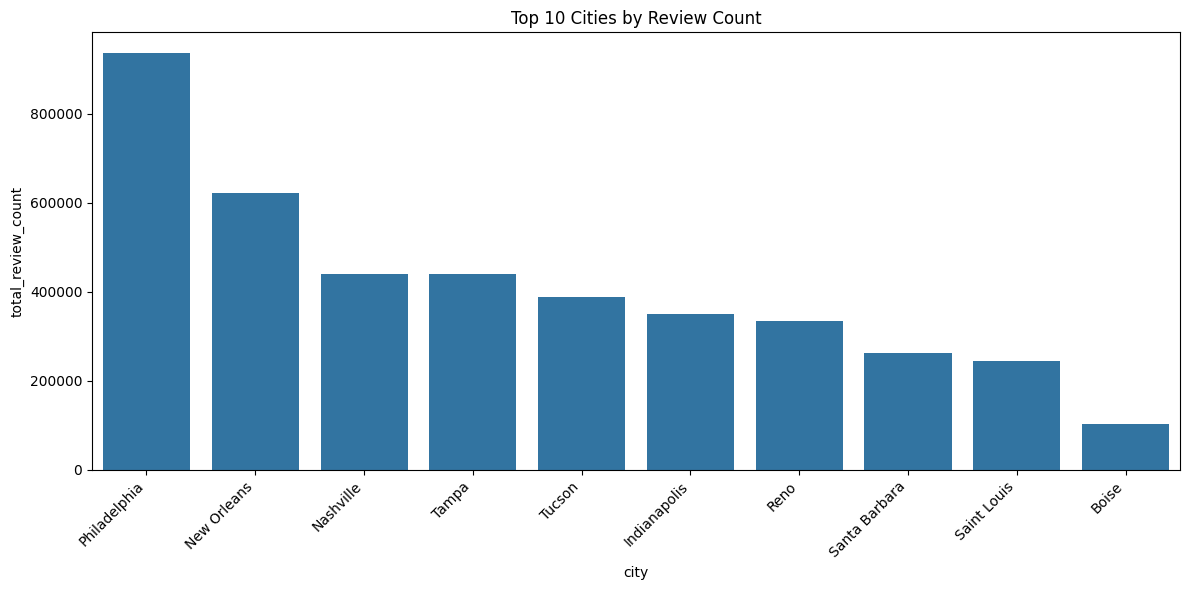

In [14]:
# Visualization 1: Top 10 Cities by Review Count
plt.figure(figsize=(12, 6))
top_10_df = df.head(10)
sns.barplot(data=top_10_df, x='city', y='total_review_count')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Cities by Review Count')
plt.tight_layout()

In [20]:
print("\nAnalyzing business categories...")

df_categories = (
    df_businesses
    .unnest("categories", "category")
    .groupby("category")
    .aggregate({
        "stars": "AVG",
        "review_count": "SUM",
        "business_id": "COUNT"
    })
    .select([
        "category AS category",
        "COUNT(business_id) AS business_count",
        "AVG(stars) AS avg_rating",
        "SUM(review_count) AS total_reviews"
    ])
    .order_by("business_count", desc=True)  # Changed to use the alias directly
    .limit(20)
)

# Execute query and convert to Pandas
cat_result = df_categories.execute()
df_cat = cat_result.to_pandas()

# Calculate category statistics
print("\nTop Categories Analysis:")
print(df_cat.head())

# Advanced Analysis: Category Performance Score
df_cat['performance_score'] = (
    df_cat['avg_rating'] * 
    np.log1p(df_cat['total_reviews']) * 
    np.log1p(df_cat['business_count'])
)

print("\nTop Categories by Performance Score:")
print(df_cat.nlargest(5, 'performance_score')[
    ['category', 'performance_score', 'avg_rating', 'total_reviews']
])


Analyzing business categories...

Executing Query: USE YelpDataverse; SELECT category AS category, COUNT(business_id) AS business_count, AVG(stars) AS avg_rating, SUM(review_count) AS total_reviews FROM Businesses b UNNEST b.categories AS category UNNEST b.categories AS category GROUP BY category ORDER BY t.total_review_count DESC, business_count DESC, business_count DESC LIMIT 20;


RuntimeError: Failed to execute query: Request failed: 400 Client Error: Bad Request for url: http://localhost:19002/query/service